# Assignment 1: GARCH modelling

**Deadline**: Sunday 21 February, 23.59.

Your notebook should run withouth errors when executed with `Run All`. Please submit your answers via [Canvas](https://canvas.uva.nl/courses/21917/assignments/197851).

|**Name**|**Student ID**|**Email**|
|:-------|:-------------|:--------|
|        |              |         |
|        |              |         |


****Hand in the following:****
* Your notebook. N.B. **click on `Kernel`, then `Restart & Run All`** before submitting, see notes.
* A (printed) pdf version of your notebook. Tip: you can use `nbconvert` ([user guide](https://nbconvert.readthedocs.io/en/latest/)) for this, or simply print the webpage to pdf.

****NOTES****:
* The assignment is a partial stand-in for a final examination, so the usual rules regarding plagiarism and fraud apply, with all attendant consequences. Code found on the internet or elsewhere is not acceptable as a solution.
* Before submitting your work, **click on `Kernel`, then `Restart & Run All`** and verify that your notebook produces the desired results and does not error.
* If your function uses random numbers, then set the seed to 0 before calling it. This makes it much easier to grade the assignments (at least as long as the answer is correct).


**Declaration of Originality**:

By submitting these answers, we declare that
1. We have read and understood the notes above.
2. These solutions are solely our own work.
3. We have not made these solutions available to any other student.



---

## Introduction

This is an assignment about the selection, estimation, testing and Monte Carlo simulation of GARCH models for daily stock index returns. 

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.tsa.arima_model import ARMA
from statsmodels.compat import lzip
from scipy import stats
import seaborn as sns
!pip install git+git://github.com/khrapovs/skewstudent
from skewstudent import SkewStudent

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


  Cloning git://github.com/khrapovs/skewstudent to /tmp/pip-req-build-nt6f9k8u
  Running command git clone -q git://github.com/khrapovs/skewstudent /tmp/pip-req-build-nt6f9k8u
  Created wheel for skewstudent: filename=skewstudent-1.0-cp36-none-any.whl size=5903 sha256=e51916bd5dfc8ae134a6de8f6e5df503e712ab649ced2ac5de4768d6e03d6659
  Stored in directory: /tmp/pip-ephem-wheel-cache-o_unk2qk/wheels/9f/64/de/0392851dcd9a00a7651659831866c7909499094f813c4224e4
Successfully built skewstudent


In [2]:
import pandas_datareader.data as web

#### FTSE data

First download data on the FTSE 100 index for the period January 1, 1998 $-$ January 29, 2021, from Yahoo Finance using `pandas-datareader` ([example](https://pydata.github.io/pandas-datareader/devel/remote_data.html#remote-data-yahoo) and [function reference](https://pydata.github.io/pandas-datareader/devel/readers/yahoo.html)).

*Hint*:  use `'%5EFTSE%3FP%3DFTSE'` as ticker symbol. Using `'^FTSE'` doesn't work, likely this is because of some labeling/referencing issue within Yahoo Finance.

In [3]:
df = pd.DataFrame()
start = pd.datetime(1998,1,1)
end = pd.datetime(2021,1,29)
FTSE100 = web.DataReader('%5EFTSE%3FP%3DFTSE','yahoo',start,end)
# We use the closing price of each day
df['ftse'] = FTSE100['Adj Close']
df['log_ftse'] = np.log(FTSE100['Adj Close'])
df.dropna(inplace=True)
df['perc_log_return'] = (df.log_ftse - df.log_ftse.shift(1))*100
df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,ftse,log_ftse,perc_log_return
Date,,,
1998-01-02,5193.500000,8.555163,NaN
1998-01-05,5262.500000,8.568361,1.319836
1998-01-06,5264.399902,8.568722,0.036096
1998-01-07,5224.100098,8.561038,-0.768461
1998-01-08,5237.100098,8.563523,0.248538
...,...,...,...
2021-01-25,6638.899902,8.800702,-0.842966
2021-01-26,6654.000000,8.802973,0.227191
2021-01-27,6567.399902,8.789873,-1.310018


###GARCH in Python

Make sure that the `arch` package is installed before importing it. It holds functionality to estimate GARCH models.

Uncomment the next line to install. Note: `!` executes shell commands.

In [4]:
!pip install arch 

In [5]:
from arch import arch_model

## Questions

1. Use the theory explained in the book and the lecture notes to select, estimate and test an empirical ARMA-GARCH model for the daily log-returns (in percentages: $r_t = 100 \cdot \Delta \log P_t$). Report on your findings, paying attention to the following elements:
    
    1. Testing for autocorrelation in the returns: is there any need for ARMA terms, and if so, what would be useful order $p$ and $q$ to start with?

    2. Testing for volatility clustering: what type of ARCH or GARCH model would be suitable?

    3. Estimation and testing of a selected ARMA-GARCH model. Do the standardised residuals behave as homoskedastic white noise, according to the available tests? Have you taken appropriate account of possible asymmetry in the news impact curve? Is the standard normal distribution appropriate for the standardised residuals, or would it be better to use another distribution?

    4. If any of the tests under 1.C indicate room for improvement, then adapt or extend the model, and check wether the revised model passes the tests.

    5. Make a plot of the estimated volatility from your final model, and also make a graph of the estimated news impact curve.
    
    
2. Use the model estimated under 1, and the resulting residual $\hat{a}_{T}$ and estimated volatility $\hat{\sigma}_{T}$ for **January 29, 2021**, to simulate the conditional distribution of the index return over the following 21 trading days (about a month). You will have to simulate the daily returns $r_{T+1},\ldots ,r_{T+21}$, to obtain a simulation of total monthly return $r[21]_{T+21}=\sum_{t=1}^{21}r_{T+t}$. The function `simulation` provides a starting point for such an analysis, but you will have to complete the program with the information from your empirical analysis in the first part. After completing the program, analyse the outcomes and report on your findings, paying attention to the following:

    1. What is the standard deviation of the monthly return? Is this what you would expect from the average daily standard deviation of the returns over the last 21 years? If not, can you give an explanation for the difference? <br> [*Note*: an approximation of the $n$-period (average) volatility is $\sqrt{n}$ times the 1-period (average) volatility; this approximation is based on the assumption of uncorrelated returns.]

    2. What is the shape of the distribution of the monthly returns? Does it display skewness and/or excess kurtosis? Can you explain these findings from the model you have used for the simulations?

    3. It may be of interest to experiment a little with the effect of different parameter values on the outcomes under A. and B.; for example, you could compare the results with and without asymmetric (leverage) effects. Also you could choose another month (corresponding to other $r_{T}$, $\hat{a}_{T}$ and $\hat{\sigma}_{T}$ to start the simulation), and compare the result. 


###1.a)


In [6]:
df.describe()

,ftse,log_ftse,perc_log_return
count,5816.000000,5816.000000,5815.000000
mean,5907.710418,8.669603,0.003612
std,967.816598,0.173251,1.204978
min,3287.000000,8.097731,-11.511706
25%,5274.650024,8.570668,-0.557872
50%,5980.250000,8.696218,0.042179
75%,6578.174805,8.791513,0.605554
max,7877.500000,8.971766,9.384244


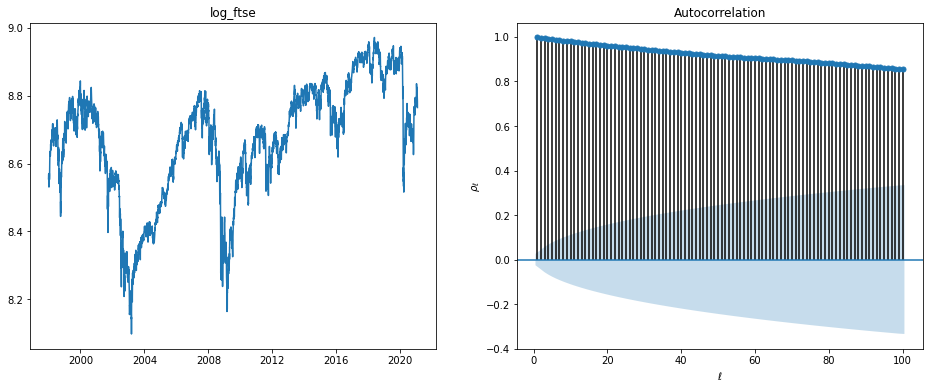

In [7]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6));
ax[0].plot(df.log_ftse);
ax[0].set_title('log_ftse')
tsaplots.plot_acf(df.log_ftse, lags=100, ax = ax[1], zero=False)
ax[1].set_ylabel(r'$\rho_\ell$')
ax[1].set_xlabel(r'$\ell$');

In the graph of the log of the FTSE we see that it stays away from its mean for long periods of time (several years), so the process is not stationary.

If we look at the autocorrelation function then we see that it decays very slowly. This is indicative of it being a nonstationary process. We can apply differencing in the hope of obtaining a stationary process that way (this will work if the process from the graph above is indeed I(1)).

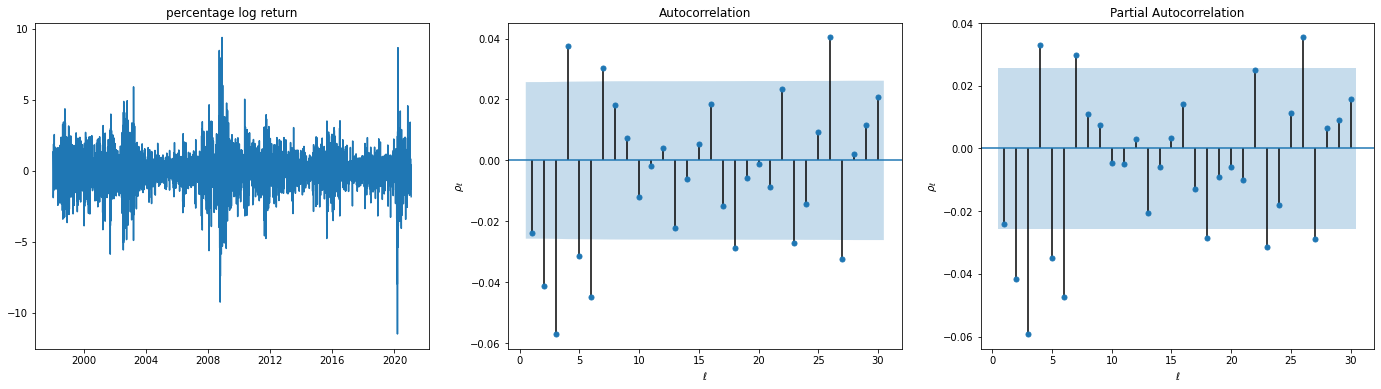

In [8]:
fig,ax = plt.subplots(nrows=1, ncols=3, figsize=(24,6));
ax[0].plot(df.perc_log_return);
ax[0].set_title('percentage log return')
tsaplots.plot_acf(df.perc_log_return.dropna(), lags=30, ax = ax[1], zero=False)
ax[1].set_ylabel(r'$\rho_\ell$')
ax[1].set_xlabel(r'$\ell$');
tsaplots.plot_pacf(df.perc_log_return.dropna(), lags=30, ax = ax[2], zero=False)
ax[2].set_ylabel(r'$\rho_\ell$')
ax[2].set_xlabel(r'$\ell$');

The graph of the percentage log return seems like that of a stationary process (possibly with volatility clustering) because it seems to reverts back to its mean. Both the autocorrelation function and the partial autocorrelation function do not seem to start being zero from some time on, so an AR(p) model or an MA(q) model is unlikely to suffice. Therefore, we look into using an ARMA(p,q) model. For the parameters p and q, it makes sense to first look at small values of these parameters so that we can avoid any overfitting that would result from adding too many parameters. Therefore, setting p = 1 and q = 1 is a good way to start.

In [9]:
p = 1
q = 1
arma11 = ARMA(df.perc_log_return.dropna(), order=(p,q)) # Give the (p,q) order of the ARMA(p,q) model
results = arma11.fit()
print(results.summary2())
results.params

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                            Results: ARMA
Model:               ARMA             BIC:                 18683.3797
Dependent Variable:  perc_log_return  Log-Likelihood:      -9324.4   
Date:                2021-02-21 21:56 Scale:               1.0000    
No. Observations:    5815             Method:              css-mle   
Df Model:            3                Sample:              0         
Df Residuals:        5812                                  5         
Converged:           1.0000           S.D. of innovations: 1.203     
No. Iterations:      16.0000          HQIC:                18665.984 
AIC:                 18656.7069                                      
---------------------------------------------------------------------
                       Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
---------------------------------------------------------------------
const                  0.0037   0.0133  0.2767 0.7820 -0.0225  0.0298
ar.L1.perc_log_return  0.7342   0.0933  7.8663 0

const                    0.003692
ar.L1.perc_log_return    0.734171
ma.L1.perc_log_return   -0.775121
dtype: float64

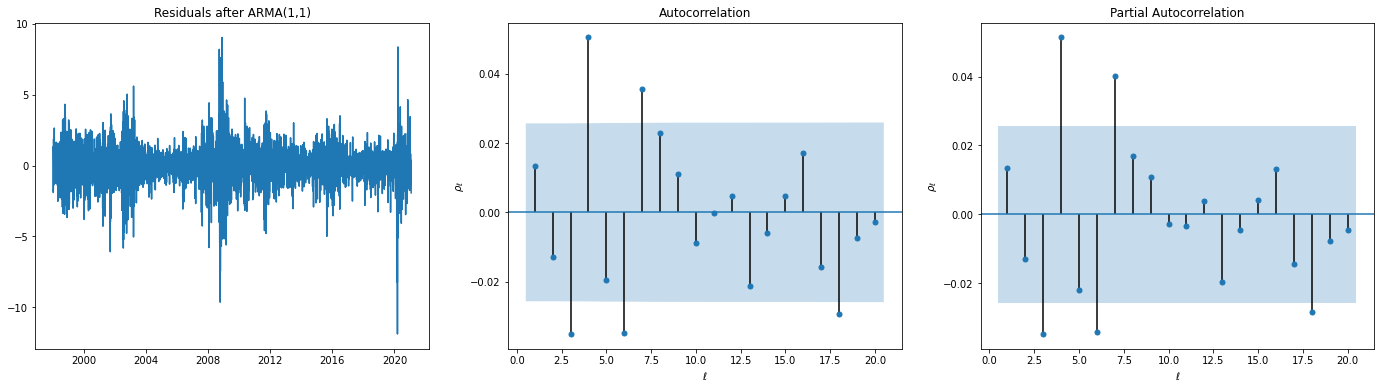

In [10]:
fig,ax = plt.subplots(nrows=1, ncols=3, figsize=(24,6));
ax[0].plot(results.resid);
ax[0].set_title('Residuals after ARMA(1,1)')
tsaplots.plot_acf(results.resid, lags=20, ax = ax[1], zero=False)
ax[1].set_ylabel(r'$\rho_\ell$')
ax[1].set_xlabel(r'$\ell$');
tsaplots.plot_pacf(results.resid, lags=20, ax = ax[2], zero=False)
ax[2].set_ylabel(r'$\rho_\ell$')
ax[2].set_xlabel(r'$\ell$');

The PACF is indicative of the AR part of the process and the ACF is indicative of the MA part of the model. From this graph we can see that the ARMA(1,1) doesn't seem to suffice. If we look at both the ACF and the PACF we can see that the cutoff of both function seems to be at lag 6, so we will try to fit the ARMA(6,6) model.  

In [11]:
p = 6
q = 6
arma11 = ARMA(df.perc_log_return.dropna(), order=(p,q)) # Give the (p,q) order of the ARMA(p,q) model
results = arma11.fit()
print(results.summary2())
results.params

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                            Results: ARMA
Model:               ARMA             BIC:                 18722.5478
Dependent Variable:  perc_log_return  Log-Likelihood:      -9300.6   
Date:                2021-02-21 21:57 Scale:               1.0000    
No. Observations:    5815             Method:              css-mle   
Df Model:            13               Sample:              0         
Df Residuals:        5802                                  5         
Converged:           1.0000           S.D. of innovations: 1.198     
No. Iterations:      74.0000          HQIC:                18661.664 
AIC:                 18629.1930                                      
---------------------------------------------------------------------
                       Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
---------------------------------------------------------------------
const                  0.0037   0.0140  0.2617 0.7935 -0.0238  0.0311
ar.L1.perc_log_return -0.2527   0.2344 -1.0778 0

const                    0.003660
ar.L1.perc_log_return   -0.252656
ar.L2.perc_log_return   -0.341124
ar.L3.perc_log_return   -0.163255
ar.L4.perc_log_return   -0.196637
ar.L5.perc_log_return   -0.057230
ar.L6.perc_log_return   -0.285627
ma.L1.perc_log_return    0.228600
ma.L2.perc_log_return    0.294897
ma.L3.perc_log_return    0.085360
ma.L4.perc_log_return    0.200360
ma.L5.perc_log_return    0.004717
ma.L6.perc_log_return    0.230797
dtype: float64

In [12]:
def print_acf(y, nlags=30):
    '''Prints the autocorrelations, partial autocorrelations, Q-statistics and p-values.'''
    
    # Compute (partial) autocorrelations
    acf, qstat, pvalues = sm.tsa.stattools.acf(y, nlags=nlags, qstat=True)
    pacf = sm.tsa.stattools.pacf(y, nlags=nlags)
    T = len(y)
    ci = 2/np.sqrt(T) # Asymptotic 95% significance conf. int.
    
    # Print in table
    print('%3s | %8s | %8s | %8s | %8s' %('lag','AC', 'PAC','Q-stat','p-value') )
    for l in range(len(qstat)):
        if abs(acf[l+1]) > ci:
            print('%3i | *%7.3f | %8.3f | %8.3f | %8.3f' %(l+1,acf[l+1],pacf[l+1],qstat[l],pvalues[l]) )
        else:
            print('%3i | %8.3f | %8.3f | %8.3f | %8.3f' %(l+1,acf[l+1],pacf[l+1],qstat[l],pvalues[l]) )
    print('Autocorrelation, partial autocorrelation, Q-statistic and p-value.')
    print('Stars denote that the autocorrelation is outside the 95%% confidence bounds (+/-%.3f) under i.i.d. assumption.' %ci)
    
    return acf, pacf, qstat, pvalues

lag |       AC |      PAC |   Q-stat |  p-value
  1 |   -0.001 |   -0.001 |    0.003 |    0.954
  2 |   -0.000 |   -0.000 |    0.003 |    0.998
  3 |   -0.001 |   -0.001 |    0.010 |    1.000
  4 |   -0.000 |   -0.000 |    0.010 |    1.000
  5 |   -0.001 |   -0.001 |    0.020 |    1.000
  6 |   -0.001 |   -0.001 |    0.031 |    1.000
  7 |   -0.006 |   -0.006 |    0.222 |    1.000
  8 |   -0.001 |   -0.001 |    0.231 |    1.000
  9 |   -0.003 |   -0.003 |    0.291 |    1.000
 10 |    0.003 |    0.003 |    0.341 |    1.000
 11 |   -0.003 |   -0.003 |    0.401 |    1.000
 12 |   -0.007 |   -0.007 |    0.712 |    1.000
 13 |   -0.009 |   -0.009 |    1.181 |    1.000
 14 |   -0.004 |   -0.004 |    1.269 |    1.000
 15 |    0.002 |    0.001 |    1.282 |    1.000
 16 |    0.014 |    0.014 |    2.382 |    1.000
 17 |   -0.017 |   -0.017 |    4.049 |    0.999
 18 | * -0.030 |   -0.030 |    9.233 |    0.954
 19 |   -0.009 |   -0.009 |    9.714 |    0.960
 20 |   -0.001 |   -0.002 |    9.725 |  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


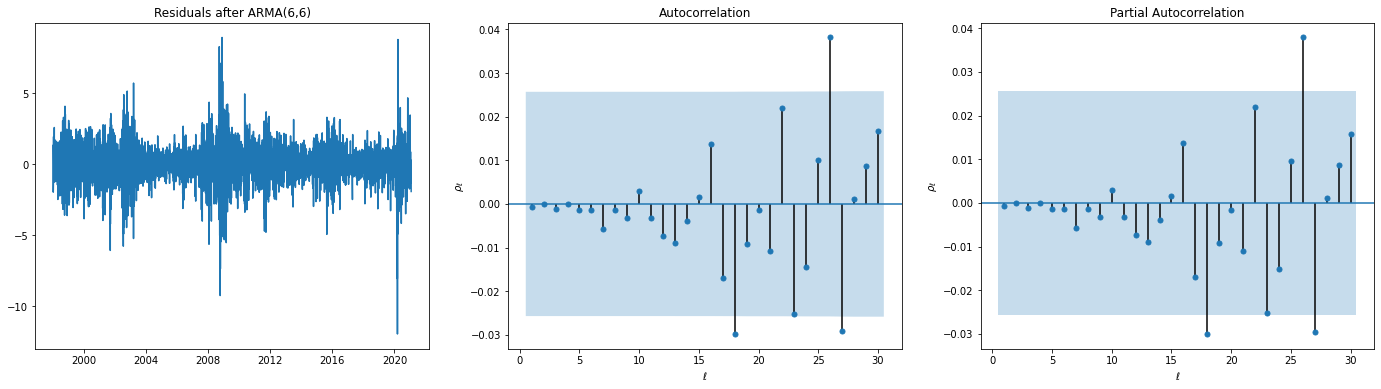

In [13]:
print_acf(results.resid) 
fig,ax = plt.subplots(nrows=1, ncols=3, figsize=(24,6));
ax[0].plot(results.resid);
ax[0].set_title('Residuals after ARMA(6,6)')
tsaplots.plot_acf(results.resid, lags=30, ax = ax[1], zero=False)
ax[1].set_ylabel(r'$\rho_\ell$')
ax[1].set_xlabel(r'$\ell$');
tsaplots.plot_pacf(results.resid, lags=30, ax = ax[2], zero=False)
ax[2].set_ylabel(r'$\rho_\ell$')
ax[2].set_xlabel(r'$\ell$');

Here we look at the  Ljung–Box statistic (Q-statistic) of the residuals, the p-value even at 30 lagas is of 0.27, so we don't reject the null hyphotesis that this data can be from a white noise process. So far the ARMA(6,6) model seems like a good fit. 

This can also seen visualy as the (P)ACF plots as the values stay mostly within the 95% confidence interval around 0. 

###1.b)


In [14]:
print('Kurtosis', df.perc_log_return.kurt())

Kurtosis 7.097488137498708


The excess kurtosis of the percentage log return is approximately 7, so it is not a homoskedastic stationary process with Gaussian white noise. Combined with the fact that we see some clustering of the positive and negative peaks, we can conclude that the data seems to indicate that there is volatility clustering involved. For modeling this type of thing, GARCH-like models are often used.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


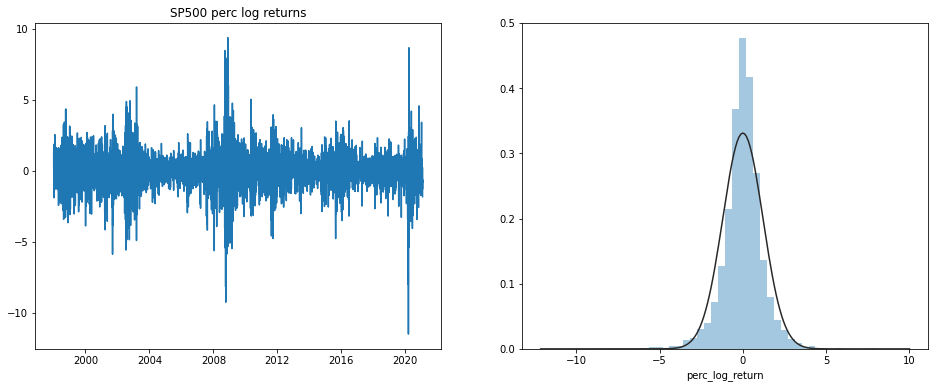

In [15]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.plot(df.perc_log_return.dropna())
plt.title('SP500 perc log returns')
plt.subplot(122)
sns.distplot(df.perc_log_return.dropna(), kde=False, fit=stats.norm);

In [16]:
print('Skewness', df.perc_log_return.skew())

Skewness -0.2953748423158725


If we look look at the distribution of the log returns plotted above we can see the impact of the high kurtosis and the slightly negative skewness of the returns.

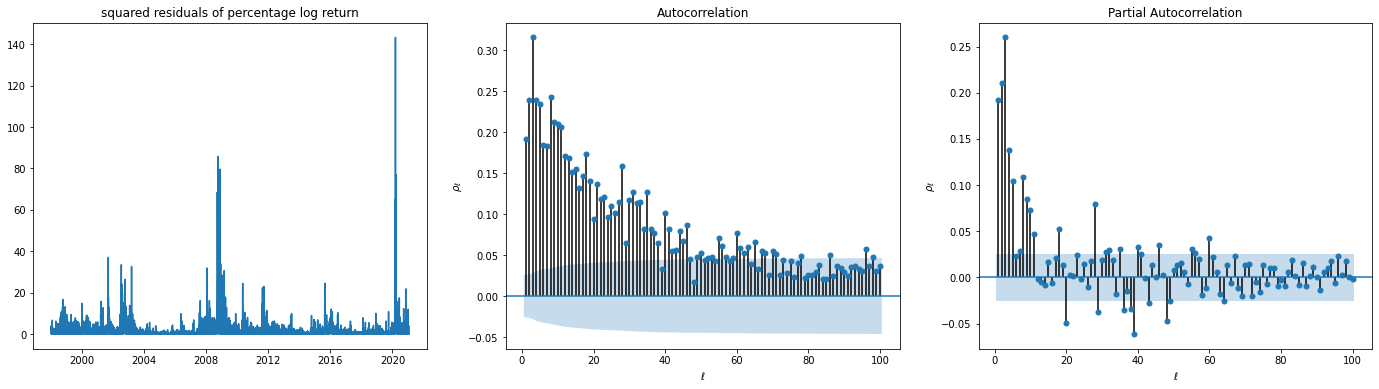

In [17]:
fig,ax = plt.subplots(nrows=1, ncols=3, figsize=(24,6));
ax[0].plot(results.resid**2);
ax[0].set_title('squared residuals of percentage log return')
tsaplots.plot_acf(results.resid**2, lags=100, ax = ax[1], zero=False)
ax[1].set_ylabel(r'$\rho_\ell$')
ax[1].set_xlabel(r'$\ell$');
tsaplots.plot_pacf(results.resid**2, lags=100, ax = ax[2], zero=False)
ax[2].set_ylabel(r'$\rho_\ell$')
ax[2].set_xlabel(r'$\ell$');

Here we plotted the ACF and the PACF of the squared residuals to see if these were stationary and to see if the process has heteroskedasticity. We see both significant autocorrelation and siginificant values of the partial autocorrelation function which suggests that we can make a better model by incorporating volatiltiy clustering.

In [18]:
print_acf(np.abs(df.perc_log_return.dropna())) 

lag |       AC |      PAC |   Q-stat |  p-value
  1 | *  0.262 |    0.262 |  398.183 |    0.000
  2 | *  0.300 |    0.249 |  923.274 |    0.000
  3 | *  0.319 |    0.223 | 1514.087 |    0.000
  4 | *  0.281 |    0.141 | 1975.351 |    0.000
  5 | *  0.292 |    0.132 | 2473.302 |    0.000
  6 | *  0.279 |    0.101 | 2927.507 |    0.000
  7 | *  0.246 |    0.050 | 3278.982 |    0.000
  8 | *  0.277 |    0.087 | 3725.051 |    0.000
  9 | *  0.255 |    0.058 | 4102.508 |    0.000
 10 | *  0.255 |    0.057 | 4480.187 |    0.000
 11 | *  0.248 |    0.044 | 4839.094 |    0.000
 12 | *  0.230 |    0.024 | 5147.300 |    0.000
 13 | *  0.242 |    0.040 | 5488.072 |    0.000
 14 | *  0.204 |   -0.006 | 5731.170 |    0.000
 15 | *  0.203 |    0.001 | 5972.202 |    0.000
 16 | *  0.213 |    0.020 | 6237.244 |    0.000
 17 | *  0.222 |    0.042 | 6524.619 |    0.000
 18 | *  0.213 |    0.031 | 6790.376 |    0.000
 19 | *  0.207 |    0.021 | 7039.462 |    0.000
 20 | *  0.185 |   -0.005 | 7238.941 |  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


(array([1.        , 0.26160999, 0.30039521, 0.31861319, 0.28149827,
        0.29245347, 0.27928812, 0.24566095, 0.27672756, 0.25453535,
        0.25458817, 0.24815882, 0.22994435, 0.24176681, 0.20418195,
        0.20329492, 0.2131621 , 0.22194172, 0.21341235, 0.20659256,
        0.18486362, 0.21695381, 0.20789323, 0.19889238, 0.18953059,
        0.17692326, 0.17416473, 0.17631726, 0.18580117, 0.14749829,
        0.17011569]),
 array([ 1.        ,  0.26165499,  0.24908867,  0.22267567,  0.14061904,
         0.13243564,  0.10131202,  0.05036501,  0.08699305,  0.0579938 ,
         0.05682778,  0.04441196,  0.02390018,  0.04018799, -0.0060968 ,
         0.0011406 ,  0.02029917,  0.04226778,  0.0307626 ,  0.02072621,
        -0.0049098 ,  0.03836896,  0.03138444,  0.02034438,  0.0062599 ,
        -0.00642512, -0.00683368,  0.00194728,  0.02352331, -0.02644807,
         0.00805167]),
 array([ 398.18271647,  923.27357985, 1514.08743902, 1975.35124353,
        2473.30178462, 2927.50721696, 327

Here we look again at the Ljung–Box statistic (Q-statistic) but this time of the absolute value of the residuals. Since all the p-values equal 0, we clearly reject the null hyphotesis and conclude that it exhibits serial correlation. (This is due to volatility clustering)

Next we will resume by doing the ARCH-LM Test.

In [19]:
name = ['LM','p-value (LM)','F','p-value (F)']
test = sm.stats.diagnostic.het_arch(np.abs(df.perc_log_return.dropna()), store=False, ddof=p+q)
lzip(name, test)

[('LM', 1306.1743145578864),
 ('p-value (LM)', 1.251772262380477e-252),
 ('F', 49.33006885126817),
 ('p-value (F)', 1.415341587994757e-288)]

This is a test of the conditional heteroscedasticy or the squared returns. From the results we can see that the p-value of the Lagrange Multiplier and of the F-statistic are extremely small, so we reject the Null-hyphotesis that the values of the coefficients in an ARCH-model setting should be all equal to zero. 

Skewness -0.3987515575262098


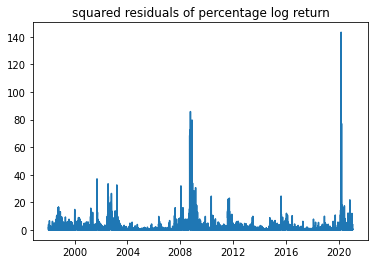

In [20]:
print("Skewness" ,results.resid.skew())
plt.plot(results.resid**2);
plt.title('squared residuals of percentage log return')
plt.show()

For modeling the heteroskedasticity of the data, GARCH-like models are very suitable. Although ARCH might work, the GARCH model provides more flexibility and is thus more likely to work.

If we look at the graph above we can also see that the periods where volatility are higher are usually during periods of market stress. This indicates that negative shocks are expected to increse the volatility more than larger positive shocks. This idicates that the EGARCH model might be a good solutions as it accounts for the impact of negative shocks while the ARCH and the GARCH model don't. This skewness of the returns (being negative), also points to this assumption of negative shocks have a bigger impact on volatility.

###1.c)

GARCH/EGARCH MODEL

In [21]:
# parameters to check
vols = ['EGARCH', "GARCH"]
ps = [1,2]
os = [0,1,2]
qs = [0,1,2]
ls = [1,3,5,6,7,9]
dists = ['normal', 'skewt']

# Variables to store the best results
best_aic = 20000
best_params = None
# Iteration number for progress printing
i = 0
for vol in vols:
  for p in ps:
    for o in os:
      for q in qs:
        for l in ls:
          for dist in dists:
            # Print progress
            i = i+1
            print("Iteration", i, "out of", len(vols)*len(ps)*len(os)*len(qs)*len(ls)*len(dists))
            # Fit an AR(l)-vol(p,o,q) model with dist as distribution for the innovation sequence
            am = arch_model(df.perc_log_return.dropna(), mean='AR', lags=l, vol=vol, p=p ,o=o, q=q, dist=dist)
            res = am.fit()
            # Take the model with the best Akaike Information Coefficient
            if res.aic < best_aic:
              best_aic = res.aic
              best_params = (vol, p, o, q, dist, l)

Streaming output truncated to the last 5000 lines.
Iteration 255 out of 432
Iteration:      1,   Func. Count:      9,   Neg. LLF: 9034.863110415554
Iteration:      2,   Func. Count:     22,   Neg. LLF: 9027.772023088182
Iteration:      3,   Func. Count:     34,   Neg. LLF: 9018.317738954183
Iteration:      4,   Func. Count:     46,   Neg. LLF: 8982.60042169956
Iteration:      5,   Func. Count:     58,   Neg. LLF: 8943.174775001802
Iteration:      6,   Func. Count:     71,   Neg. LLF: 8941.01577148326
Iteration:      7,   Func. Count:     81,   Neg. LLF: 8928.1135364945
Iteration:      8,   Func. Count:     91,   Neg. LLF: 8926.832338946366
Iteration:      9,   Func. Count:    102,   Neg. LLF: 8926.470602032201
Iteration:     10,   Func. Count:    111,   Neg. LLF: 8925.525844470218
Iteration:     11,   Func. Count:    120,   Neg. LLF: 8925.499712151024
Iteration:     12,   Func. Count:    129,   Neg. LLF: 8925.498978437374
Iteration:     13,   Func. Count:    138,   Neg. LLF: 8925.49897

In the above, we tried multiple model (hyper)parameters and used the one which had the highest AIC. While getting a better (log) likelihood is better, it should be kept in mind that introducing additional parameters could lead to overfitting. The AIC makes a trade off between the log likelihood of the model and the number of parameters used.

In [22]:
import math
print(best_aic, best_params)
#best_params=('EGARCH',1,1,1, 'skewt', 6)
am = arch_model(df.perc_log_return.dropna(), mean='AR', lags=best_params[5], vol=best_params[0], p=best_params[1],o=best_params[2],q=best_params[3], dist=best_params[4])
res = am.fit()  # Fit model
print(res.summary())
#res.arch_lm_test()

15977.141842329896 ('EGARCH', 2, 2, 1, 'skewt', 9)
Iteration:      1,   Func. Count:     20,   Neg. LLF: 8053.205439006811
Iteration:      2,   Func. Count:     44,   Neg. LLF: 8042.74294951837
Iteration:      3,   Func. Count:     69,   Neg. LLF: 8028.579099354643
Iteration:      4,   Func. Count:     94,   Neg. LLF: 8025.639896394477
Iteration:      5,   Func. Count:    118,   Neg. LLF: 8015.351217084506
Iteration:      6,   Func. Count:    142,   Neg. LLF: 8013.445169279821
Iteration:      7,   Func. Count:    166,   Neg. LLF: 8013.093455068951
Iteration:      8,   Func. Count:    190,   Neg. LLF: 8012.955413795511
Iteration:      9,   Func. Count:    215,   Neg. LLF: 8012.901004381526
Iteration:     10,   Func. Count:    238,   Neg. LLF: 8011.960908472208
Iteration:     11,   Func. Count:    262,   Neg. LLF: 8011.794374254707
Iteration:     12,   Func. Count:    284,   Neg. LLF: 8007.939531800574
Iteration:     13,   Func. Count:    306,   Neg. LLF: 7986.753880629478
Iteration:    

From simulation we can confirm what he previously assumed that the EGARCH model obatains better results than the GARCH model. From the AIC we see that the best model to fit is the EGARCH(2,1), with an AIC of 15977.1. For simplicity sake, and because the AIC doesn't seem to drop that much, we will resume our report using the EGARCH(1,1) model, that obtains an AIC of 15994.6. 


In [23]:
import math
#print(best_aic, best_params)
best_params=('EGARCH',1,1,1, 'skewt', 6)
am = arch_model(df.perc_log_return.dropna(), mean='AR', lags=best_params[5], vol=best_params[0], p=best_params[1],o=best_params[2],q=best_params[3], dist=best_params[4])
res = am.fit()  # Fit model
print(res.summary())
#res.arch_lm_test()

Iteration:      1,   Func. Count:     15,   Neg. LLF: 8045.042466633063
Iteration:      2,   Func. Count:     36,   Neg. LLF: 8022.7514790383675
Iteration:      3,   Func. Count:     55,   Neg. LLF: 8015.621331756515
Iteration:      4,   Func. Count:     74,   Neg. LLF: 8013.138877921244
Iteration:      5,   Func. Count:     93,   Neg. LLF: 8012.210440564211
Iteration:      6,   Func. Count:    112,   Neg. LLF: 8012.047505217472
Iteration:      7,   Func. Count:    131,   Neg. LLF: 8011.929663866598
Iteration:      8,   Func. Count:    148,   Neg. LLF: 8009.497834845549
Iteration:      9,   Func. Count:    164,   Neg. LLF: 7986.890852110325
Iteration:     10,   Func. Count:    182,   Neg. LLF: 7985.89970776809
Iteration:     11,   Func. Count:    201,   Neg. LLF: 7985.891352976838
Iteration:     12,   Func. Count:    219,   Neg. LLF: 7985.873153863778
Iteration:     13,   Func. Count:    236,   Neg. LLF: 7985.626395151281
Iteration:     14,   Func. Count:    252,   Neg. LLF: 7985.01375

p-value for homoskedasticity (ARCH LM test) 0.2686404036890153
p-value for white noise (Q-statistic) 0.5897707641362849


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


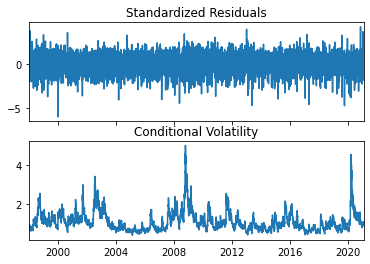

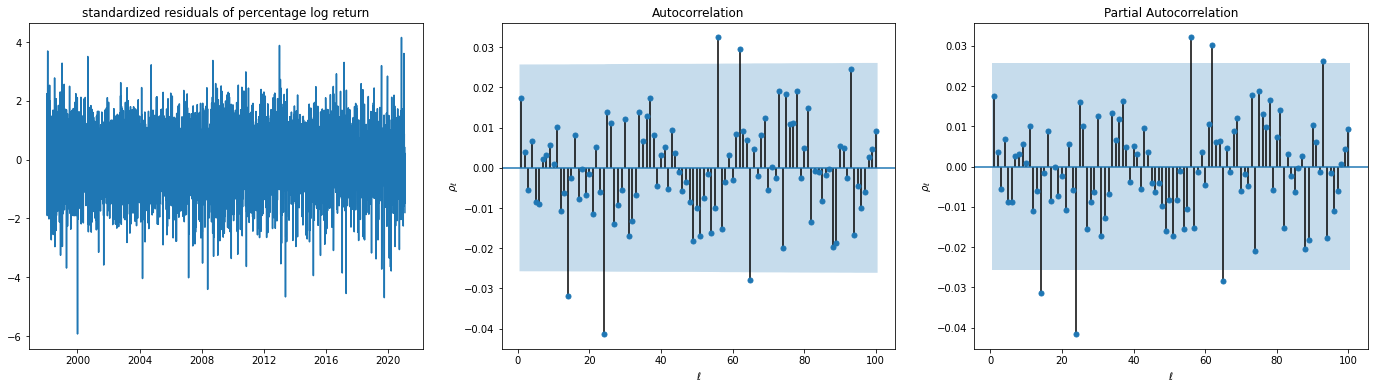

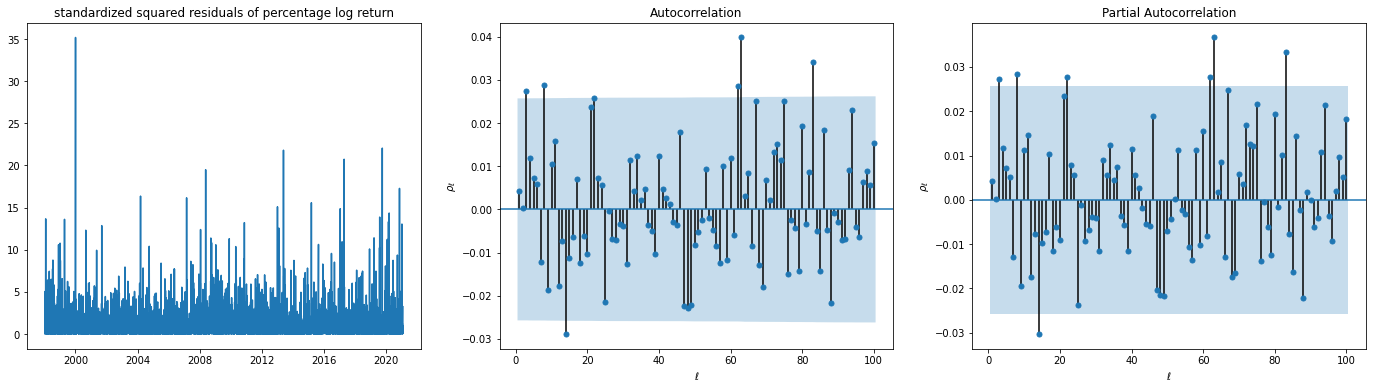

In [24]:
print('p-value for homoskedasticity (ARCH LM test)', sm.stats.diagnostic.het_arch(res.std_resid.dropna(), store=False, ddof=p+q)[1])
print('p-value for white noise (Q-statistic)', sm.tsa.stattools.acf(res.std_resid.dropna(), nlags=30, qstat=True)[2][29])
plt.close()
res.plot()
plt.show()
plt.close()

fig,ax = plt.subplots(nrows=1, ncols=3, figsize=(24,6));
ax[0].plot(res.std_resid.dropna());
ax[0].set_title('standardized residuals of percentage log return')
tsaplots.plot_acf(res.std_resid.dropna(), lags=100, ax = ax[1], zero=False)
ax[1].set_ylabel(r'$\rho_\ell$')
ax[1].set_xlabel(r'$\ell$');
tsaplots.plot_pacf(res.std_resid.dropna(), lags=100, ax = ax[2], zero=False)
ax[2].set_ylabel(r'$\rho_\ell$')
ax[2].set_xlabel(r'$\ell$');

fig,ax = plt.subplots(nrows=1, ncols=3, figsize=(24,6));
ax[0].plot(res.std_resid.dropna()**2);
ax[0].set_title('standardized squared residuals of percentage log return')
tsaplots.plot_acf(res.std_resid.dropna()**2, lags=100, ax = ax[1], zero=False)
ax[1].set_ylabel(r'$\rho_\ell$')
ax[1].set_xlabel(r'$\ell$');
tsaplots.plot_pacf(res.std_resid.dropna()**2, lags=100, ax = ax[2], zero=False)
ax[2].set_ylabel(r'$\rho_\ell$')
ax[2].set_xlabel(r'$\ell$');

We have run the Lagrange Multiplier test on the squared standardized residuals. This results in a value of around $0.27$ which means that we do not reject the null hypothesis of the standardized residuals being homoskedastic. Furthermore we see that the standardized residuals behave as white noise according to the Ljung-Box statistic with a p-value of $0.59$ at lag 30. So we conclude from these statistics that the standardized residuals behave as homoskedastic white noise. 

In terms of the news-impact curve (NIC) we also took that into account when selecting the EGARCH model. Because the EGARCH model accounts for assymetry in the NIC which is more realistic than the ARRCH and GARCH model as previously mentioned.  

15977.141842329896 ('EGARCH', 1, 1, 1, 'skewt', 6)
Iteration:      1,   Func. Count:     13,   Neg. LLF: 8087.71691855004
Iteration:      2,   Func. Count:     30,   Neg. LLF: 8068.598401467927
Iteration:      3,   Func. Count:     47,   Neg. LLF: 8066.096836670223
Iteration:      4,   Func. Count:     64,   Neg. LLF: 8064.687467840405
Iteration:      5,   Func. Count:     81,   Neg. LLF: 8063.766394204421
Iteration:      6,   Func. Count:     98,   Neg. LLF: 8063.544167889919
Iteration:      7,   Func. Count:    115,   Neg. LLF: 8063.53162027044
Iteration:      8,   Func. Count:    131,   Neg. LLF: 8063.524750280933
Iteration:      9,   Func. Count:    146,   Neg. LLF: 8062.551983435808
Iteration:     10,   Func. Count:    162,   Neg. LLF: 8057.2276801242515
Iteration:     11,   Func. Count:    179,   Neg. LLF: 8057.210310564896
Iteration:     12,   Func. Count:    195,   Neg. LLF: 8057.207685706937
Iteration:     13,   Func. Count:    209,   Neg. LLF: 8057.012455453565
Iteration:    

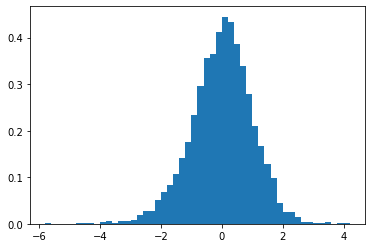

In [25]:
import math
print(best_aic, best_params)
params=('EGARCH',1,1,1, 'normal', 6)
am = arch_model(df.perc_log_return.dropna(), mean='AR', lags=params[5], vol=params[0], p=params[1],o=params[2],q=params[3], dist=params[4])
res = am.fit()  # Fit model
plt.hist(res.std_resid.dropna(), density=True, bins=50)
print('p-value for normality', stats.jarque_bera(res.std_resid.dropna())[1])
print("Skewness", res.std_resid.skew())
params=('EGARCH',1,1,1, 'skewt', 6)
am = arch_model(df.perc_log_return.dropna(), mean='AR', lags=params[5], vol=params[0], p=params[1],o=params[2],q=params[3], dist=params[4])
res = am.fit()  # Fit model



We also tried running the model with a normal distribution for the residuals but in this case we actually end up with standardized residuals that do not look normal according to the graph and for which the Jargue Bera statistic rejects normality with a p-value of 0.

Visualy we can also see that the graph looks skewd and by printing the value of the skewnness of  -0.33. 

We decided in the end to go with a skew T distribution. This also results in a higher AIC of the model.

###1.d)

As described above, we tried many different model parameters algorithmically. In the end we are satisfied with the models included above since they pass the diagnostic tests.

###1.e)

The formula for the EGARCH model that is used by the arch_model function is given by:
$$\ln\sigma_{t}^{2}=\omega
        +\sum_{i=1}^{p}\alpha_{i}
        \left(\left|\epsilon_{t-i}\right|-\sqrt{2/\pi}\right)
        +\sum_{j=1}^{o}\gamma_{j} \epsilon_{t-j}
        +\sum_{k=1}^{q}\beta_{k}\ln\sigma_{t-k}^{2}
$$
where $\epsilon_{t}=a_{t}/\sigma_{t}$.\
In our case we have the EGARCH(1,1) model, therefore we have that:
$$\ln\sigma_{t}^{2}=\omega+\alpha
        \left(\left|e_{t-1}\right|-\sqrt{2/\pi}\right)
        +\gamma e_{t-1}
        +\beta\ln\sigma_{t-1}^{2}
$$
Where $\omega=1.4025e{-03}$, $\alpha=0.1253$, $\gamma=-0.1140$, $\beta= 0.9844$. (This results are taken from the res.summary() function)
So to calculate the news impact we want to see what the impact of previous values of the process of future volatility. Remark: The  EGARCH  model  is asymmetric because,  positive return  shocks generate less volatility  then  negative  return shocks, all  else being  equal.
The news Impact curve is given by: 
\begin{align*}
    \sigma^2_t &= A ⋅\exp[ (\gamma+ \alpha)\epsilon_{t-1}], \text{for } \epsilon_{t-1}>0 , \text{ and}\\
    \sigma^2_t &= A ⋅\exp[ (\gamma- \alpha)\epsilon_{t-1} ], \text{for }  \epsilon_{t-1}<0,
\end{align*}
where $A \equiv \sigma^{2\beta}\cdot \exp [ \omega - \alpha\cdot\sqrt{\frac{2}{\pi}} ]$

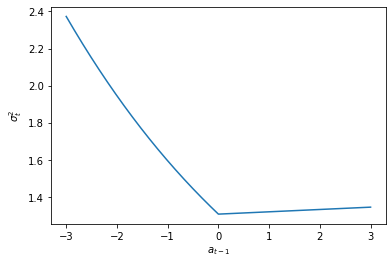

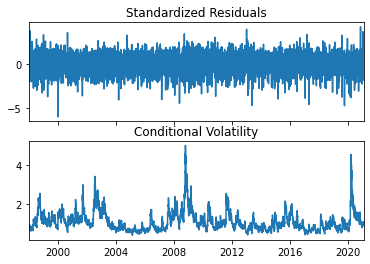

In [26]:
#News Impact Curve
es = np.linspace(-3,3,1000)
var = np.var(df.perc_log_return.dropna())
A = var ** res.params['beta[1]'] * math.exp(res.params['omega'] - res.params['alpha[1]'] * math.sqrt(2/math.pi))
def computeNIC(a):
  if a > 0:
    return A* np.exp((res.params['gamma[1]']+res.params['alpha[1]'])/math.sqrt(var)*a)
  else:
    return A* np.exp((res.params['gamma[1]']-res.params['alpha[1]'])/math.sqrt(var)*a)
plt.plot(es, list(map(computeNIC, es)))
plt.xlabel('$a_{t-1}$')
plt.ylabel('$\sigma_t^2$')
plt.show()
plt.close()
res.plot()
plt.show()



Here we ploted the news impact curve of the EGARCH model news impact curve, which is very similar to the theoritical one seen in class.

We also ploted estimated volatility from our model, here we can definatevely see how negative shocks have a bigger impact on the volatility in the EGARCH as wee look at the 2008 peak (Financial Crisis) and the 2020 peak (Covid Crisis). 

###2.a)


In this simulation we ran the ARMA(1,1) model because running an ARMA(p,q) of higher order would take making significant alterations to the code provided for running the simulation. So for simplicity sake we will use the ARMA(1,1)-EGARCH(1,1).

In [27]:
p = 1
q = 1
arma11 = ARMA(df.perc_log_return.dropna(), order=(p,q)) # Give the (p,q) order of the ARMA(p,q) model
results = arma11.fit()
results.params

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


const                    0.003692
ar.L1.perc_log_return    0.734171
ma.L1.perc_log_return   -0.775121
dtype: float64

In [28]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
%matplotlib inline
import matplotlib.pyplot as plt
# ARMA(1,1)-EGARCH(1,1,1, 'skewt')

def computeConditionalVolatility(prev_epsilon, prev_sigma2):
  A = prev_sigma2 ** res.params['beta[1]'] * math.exp(res.params['omega'] - res.params['alpha[1]'] * math.sqrt(2/math.pi)) 
  if prev_epsilon > 0:
    return A* np.exp((res.params['gamma[1]']+res.params['alpha[1]'])*prev_epsilon)
  else:
    return A* np.exp((res.params['gamma[1]']-res.params['alpha[1]'])*prev_epsilon)

def simulation(params, rT, aT, sT, R=2000, m=22):
    '''
    Simulating the distribution of a monthly return from a daily ARMA-GARCH model.
    
    Notes: 
    * Need to fill in an expression for s2 and r depending on the model for the conditional volatility and mean.
    * The program is applicable if only one lag / starting value is needed, e.g. ARMA(1,1)-GARCH(1,1); 
      for higher-order models the program needs adjustment.
        
    INPUT
    -----
    params: parameter vector (both mean and volatility parameters) from ARMAResults
    
    R: number of replications
    m: number of trading days in a month (~21 days), plus one starting value (change this if more starting values are needed)
    
    Starting values (if more lags are involved, then more values from January 2020 are needed)
    rT: the daily return at time of forecasting
    aT: the residual at time of forecasting
    sT: the estimated volatility at time of forecasting
     
    
    OUTPUT
    ------
    monthreturn: array with R simulated monthly returns
    
    '''
    np.random.seed(0)
    # Define variables
    r = np.zeros(m+1)  # daily returns
    a = np.zeros(m+1)  # disturbances
    s2 = np.zeros(m+1)  # conditional variance
    epsilon = np.zeros(m+1)  # standardized disturbances
    monthreturn = np.zeros(R)  # monthly return
           
    # Initialising various variables at the relevant starting values
    r[0] = rT
    a[0] = aT
    s2[0] = sT**2
    epsilon[0] = aT / sT

    # Draw R times the monthly return according to the ARMA-GARCH specification
    for rep in range(R):
        # use random number generator from other distribution for epsilon if necessary
        if 'dist' in params and params['dist'] == 'normal':
          epsilon[1:] = np.random.randn(m)
        else:
          epsilon[1:] = SkewStudent(lam=res.params['lambda'], eta=res.params['nu']).rvs(size=m)
        
        # use estimated GARCH equation, expressing conditional variance s2 in terms of s2[h-1] and epsilon[h-1]
        for h in range(1,m):
            # EGARCH(1,1)
            s2[h] = computeConditionalVolatility(epsilon[h-1], s2[h-1])
            
        
        a[1:] = np.sqrt(s2[1:])*epsilon[1:]
        
        # use estimated ARMA equation, expressing r in terms of a and possibly r[h-1] and/or a[h-1]
        for h in range(1,m):
            r[h] = results.params['const'] + a[h]
            for i in range(p):
              r[h] += results.params['ar.L' + str(i+1) + '.perc_log_return'] * r[h-i]
            for i in range(q):
              r[h] -= results.params['ma.L' + str(i+1) + '.perc_log_return'] * a[h-i]
        monthreturn[rep] = sum(r[1:])
        
    return monthreturn

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                            Results: ARMA
Model:               ARMA             BIC:                 18683.3797
Dependent Variable:  perc_log_return  Log-Likelihood:      -9324.4   
Date:                2021-02-21 22:00 Scale:               1.0000    
No. Observations:    5815             Method:              css-mle   
Df Model:            3                Sample:              0         
Df Residuals:        5812                                  5         
Converged:           1.0000           S.D. of innovations: 1.203     
No. Iterations:      16.0000          HQIC:                18665.984 
AIC:                 18656.7069                                      
---------------------------------------------------------------------
                       Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
---------------------------------------------------------------------
const                  0.0037   0.0133  0.2767 0.7820 -0.0225  0.0298
ar.L1.perc_log_return  0.7342   0.0933  7.8663 0

(array([  2.,   1.,   7.,  21.,  54., 170., 436., 676., 530., 103.]),
 array([-88.11141681, -76.12205439, -64.13269196, -52.14332954,
        -40.15396711, -28.16460469, -16.17524226,  -4.18587984,
          7.80348259,  19.79284501,  31.78220744]),
 <a list of 10 Patch objects>)

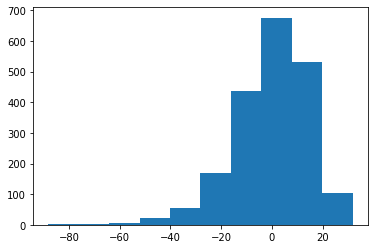

In [29]:
p = 1#best_params[0]
q = 1#best_params[1]
arma11 = ARMA(df.perc_log_return.dropna(), order=(p,q)) # Give the (p,q) order of the ARMA(p,q) model
results = arma11.fit()
print(results.summary2())

sims = simulation([], df.perc_log_return[-1], res.resid[-1], res.conditional_volatility[-1])
plt.hist(sims)

In [30]:
print(pd.DataFrame(sims).describe())

                 0
count  2000.000000
mean     -0.330002
std      14.578346
min     -88.111417
25%      -8.526895
50%       1.436921
75%       9.809259
max      31.782207


From here we can see that the standard deviation of the monthly return is 14.578346

In [31]:
np.std(df.perc_log_return)*math.sqrt(22)

5.651360198990237

Based on the standard deviation of the daily average log returns, we have computed (under the assumption of independence and multivariate normality / sum-stability) that the standard deviation of the average monthly log returns should be 5.65. However, there are two assumption that do not hold here. First of all, the log returns are not normally distributed. Secondly, the conditional variance based on the last part of the stock price process is not the same as the unconditional variance (because there is volatility clustering). Because of volatility clustering, there are going to be months with high volatilty and months with low volatility and so their average (as in the unconditional volatility) is not necessarily representative of the volatility next month.

###2.b)

In [32]:
print('Skewness',pd.DataFrame(sims).skew()[0])
print('Excess Kurtosis',pd.DataFrame(sims).kurt()[0])
print('Skewness of unconditional distribution', stats.skew(df.perc_log_return.dropna()))
print('Excess Kurtosis of unconditional distribution', stats.kurtosis(df.perc_log_return.dropna()))

Skewness -0.9769832766948386
Excess Kurtosis 2.186906132475884
Skewness of unconditional distribution -0.29529864386112153
Excess Kurtosis of unconditional distribution 7.090355228425276


The skewness of the histogram in 2.a) can be explained due to the use of the EGARCH model,  positive return shocks generate less volatility then negative return shocks. Furthermore when returns are negative, changes can occur much faster, therfore we have more outliers when the returns are negative, making the graph have a negative skeweness. We can also see that the distribution of the monthly returns has excess kutosis and this can be explained by the assumption of volatility clustering in the EGARCH model.





###2.c)

In [33]:
params=('GARCH',1,1,1, 'normal', 6)
am = arch_model(df.perc_log_return.dropna(), mean='AR', lags=params[5], vol=params[0], p=1,o=1,q=1, dist=params[4])
res = am.fit()  # Fit model
print(res.summary())
print(sm.stats.diagnostic.het_arch(res.resid.dropna(), store=False, ddof=p+q))
sims = simulation({'dist': 'normal'}, df.perc_log_return[-1], res.resid[-1], res.conditional_volatility[-1])

Iteration:      1,   Func. Count:     13,   Neg. LLF: 8103.538216350396
Iteration:      2,   Func. Count:     32,   Neg. LLF: 8087.280457713432
Iteration:      3,   Func. Count:     49,   Neg. LLF: 8085.59022449271
Iteration:      4,   Func. Count:     66,   Neg. LLF: 8085.459857124251
Iteration:      5,   Func. Count:     82,   Neg. LLF: 8085.1215202542935
Iteration:      6,   Func. Count:     99,   Neg. LLF: 8085.077114597483
Iteration:      7,   Func. Count:    114,   Neg. LLF: 8084.815879094249
Iteration:      8,   Func. Count:    130,   Neg. LLF: 8084.737316831269
Iteration:      9,   Func. Count:    146,   Neg. LLF: 8084.664783209599
Iteration:     10,   Func. Count:    160,   Neg. LLF: 8080.9473216482165
Iteration:     11,   Func. Count:    175,   Neg. LLF: 8079.771493846083
Iteration:     12,   Func. Count:    189,   Neg. LLF: 8078.046870739004
Iteration:     13,   Func. Count:    204,   Neg. LLF: 8077.824809258805
Iteration:     14,   Func. Count:    218,   Neg. LLF: 8076.2737

Skewness 0.5856896148717768
Excess Kurtosis 0.6620021939924423
Skewness of unconditional distribution -0.29529864386112153
Excess Kurtosis of unconditional distribution 7.090355228425276


,0
count,2000.000000
mean,0.022147
std,11.585573
min,-30.390858
25%,-8.348599
50%,-0.766949
75%,6.834866
max,51.957614


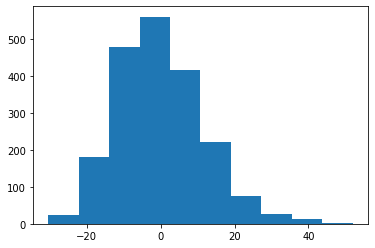

In [34]:
plt.hist(sims)
print('Skewness', stats.skew(sims))
print('Excess Kurtosis', stats.kurtosis(sims))
print('Skewness of unconditional distribution', stats.skew(df.perc_log_return.dropna()))
print('Excess Kurtosis of unconditional distribution', stats.kurtosis(df.perc_log_return.dropna()))
pd.DataFrame(sims).describe()

In our model there were two sources of asymmetric effects: the use of EGARCH instead of GARCH and the use of a skewed distribution for the innovation process, of which the former is the most important. To see what the effect of removing them is, we fit a GARCH model with normally distributed innovations to the process and examined the simulation results.

The resulting distributed is quite different. Most notably, the skewness  for the fitted GARCH model is positive instead of negative. This shows that it is important to take into account the asymmetry of the NIC because without the skewness of the predicted distribution is likely incorrect.

In [35]:
p = 1#best_params[0]
q = 1#best_params[1]
arma11 = ARMA(df.perc_log_return.dropna(), order=(p,q)) # Give the (p,q) order of the ARMA(p,q) model
results = arma11.fit()
best_params=('EGARCH',1,1,1, 'skewt', 6)
am = arch_model(df.perc_log_return.dropna(), mean='AR', lags=best_params[5], vol=best_params[0], p=best_params[1],o=best_params[2],q=best_params[3], dist=best_params[4])
res = am.fit()  # Fit model

times = np.arange(1, 5000, 100)
sim_results = []
for time in times:
  sims = simulation([], df.perc_log_return[-time], res.resid[-time], res.conditional_volatility[-time], R=100)
  sim_results.append({'time': np.array(df.reset_index('Date')['Date'])[-time], 'mean':np.mean(sims), 'std': np.std(sims), 'skew': stats.skew(sims), 'kurtosis': stats.kurtosis(sims)})
sim_results = pd.DataFrame(sim_results)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Iteration:      1,   Func. Count:     15,   Neg. LLF: 8045.042466633063
Iteration:      2,   Func. Count:     36,   Neg. LLF: 8022.7514790383675
Iteration:      3,   Func. Count:     55,   Neg. LLF: 8015.621331756515
Iteration:      4,   Func. Count:     74,   Neg. LLF: 8013.138877921244
Iteration:      5,   Func. Count:     93,   Neg. LLF: 8012.210440564211
Iteration:      6,   Func. Count:    112,   Neg. LLF: 8012.047505217472
Iteration:      7,   Func. Count:    131,   Neg. LLF: 8011.929663866598
Iteration:      8,   Func. Count:    148,   Neg. LLF: 8009.497834845549
Iteration:      9,   Func. Count:    164,   Neg. LLF: 7986.890852110325
Iteration:     10,   Func. Count:    182,   Neg. LLF: 7985.89970776809
Iteration:     11,   Func. Count:    201,   Neg. LLF: 7985.891352976838
Iteration:     12,   Func. Count:    219,   Neg. LLF: 7985.873153863778
Iteration:     13,   Func. Count:    236,   Neg. LLF: 7985.626395151281
Iteration:     14,   Func. Count:    252,   Neg. LLF: 7985.01375

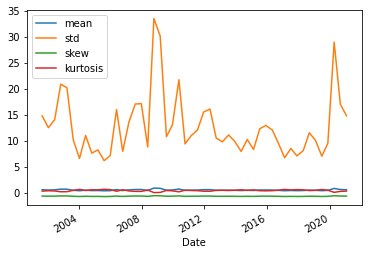

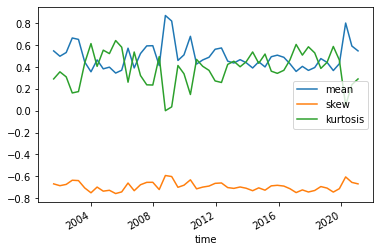

In [41]:
sim_results.set_index('time').plot()
plt.xlabel("Date")
sim_results[['time', 'mean', 'skew', 'kurtosis']].set_index('time').plot()

We ran simulations for the monthly return distributions for different periods of consecutive 22 days with the starting days 100 days apart. To make running times reasonable, we did only 100 runs for each simulation point. Therefore, it should be taken into account that some features of these results could be due to the low number of runs, especially for the higher order moments. We have plotted various statistics over time so that we can see how they depend on time. We see that the standard deviation has a lot of variation, which is of course caused by the conditional heteroskedasticity. Furthermore, we also see that the kurtosis is also dependent on time. Skewness seems to stay around zero although it does fluctuate a bit. 

In [37]:
ps = [1,2,3,4,5, 6]
qs = [1,2,3,4,5, 6]

best_aic = 20000
best_params = None
for p in ps:
  for q in qs:
    arma11 = ARMA(df.perc_log_return.dropna(), order=(p,q)) # Give the (p,q) order of the ARMA(p,q) model
    try:
      res = arma11.fit()
      if res.aic < best_aic:
        best_aic = res.aic
        best_params = (p, q)
    except:
      # For some values of p, q, ARMA throws an error saying the process is not stationary
      pass


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

We used the code above to find the best hyperparameters for the ARMA model. To determine which one is better, we used the Akaike information index which makes a trade off between likelihood and number of parameters. This resulted in p=2 and q=5

In [42]:
print(best_params)
p = best_params[0]
q = best_params[1]
arma11 = ARMA(df.perc_log_return.dropna(), order=(p,q)) # Give the (p,q) order of the ARMA(p,q) model
results = arma11.fit()
print(results.summary2())
results.params

(2, 5)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                            Results: ARMA
Model:               ARMA             BIC:                 18684.1176
Dependent Variable:  perc_log_return  Log-Likelihood:      -9303.1   
Date:                2021-02-21 22:07 Scale:               1.0000    
No. Observations:    5815             Method:              css-mle   
Df Model:            8                Sample:              0         
Df Residuals:        5807                                  5         
Converged:           1.0000           S.D. of innovations: 1.198     
No. Iterations:      26.0000          HQIC:                18644.978 
AIC:                 18624.1038                                      
---------------------------------------------------------------------
                       Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
---------------------------------------------------------------------
const                  0.0037   0.0137  0.2677 0.7889 -0.0232  0.0306
ar.L1.perc_log_return  0.1050   0.1097  0.9571 0

const                    0.003677
ar.L1.perc_log_return    0.104970
ar.L2.perc_log_return   -0.685393
ma.L1.perc_log_return   -0.130304
ma.L2.perc_log_return    0.648384
ma.L3.perc_log_return   -0.075311
ma.L4.perc_log_return    0.018373
ma.L5.perc_log_return   -0.079872
dtype: float64